In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

import h5py
import os
import json
import joblib


from sklearn.decomposition import PCA

import afterglowpy as grb

## Load the data

In [2]:
data = {}

f = h5py.File("../training_data/fluxes_tophat.h5", "r")

for key in f.keys():
    data[key] = np.array(f[key])


f.close()

In [2]:
f = h5py.File("../training_data/params_tophat.h5", "r")

params = np.array(f["parameters"])
freqs = np.array(f["frequency"])
ts = np.array(f["time"])

f.close()

## Use the PCATrainingModel class

In [5]:
from training import PCATrainingModel

pcatraining = PCATrainingModel(
                 "afterglowpy_tophat",
                 data,
                 ['log10_n0', 'theta_obs', 'log10_E0', 'thetaCore', 'p', 'log10_eps_e', 'log10_eps_b'],
                 ts,
                 freqs, 
                 50, 
                 "./pca_afterglowpy_tophat"
                 )


pca, training_data, rescaled_params = pcatraining.generate_pca_model()

Fitting PCA model with 50 components to the provided data.
PCA model accounts for a share 0.9999919598493701 of the total variance in the data.


In [6]:
pcatraining.train_tensorflow_model(1000)

2024-03-31 13:06:52.476349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-31 13:06:52.480050: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 13:06:52.524391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 13:06:52.524436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 13:06:52.525546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

 --- Training for spectra ---
Features (input) have shape (24576, 7)
Labels (output) have shape (24576, 50)
Epoch 1/1000
615/615 [==============================] - 2s 2ms/step - loss: 4.9642 - val_loss: 1.0040
Epoch 2/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.6300 - val_loss: 0.4201
Epoch 3/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.3273 - val_loss: 0.2688
Epoch 4/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.2243 - val_loss: 0.1873
Epoch 5/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.1765 - val_loss: 0.1471
Epoch 6/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.1438 - val_loss: 0.1295
Epoch 7/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.1243 - val_loss: 0.1182
Epoch 8/1000
615/615 [==============================] - 1s 2ms/step - loss: 0.1109 - val_loss: 0.0989
Epoch 9/1000
615/615 [==============================] - 1s 1ms/step - loss: 

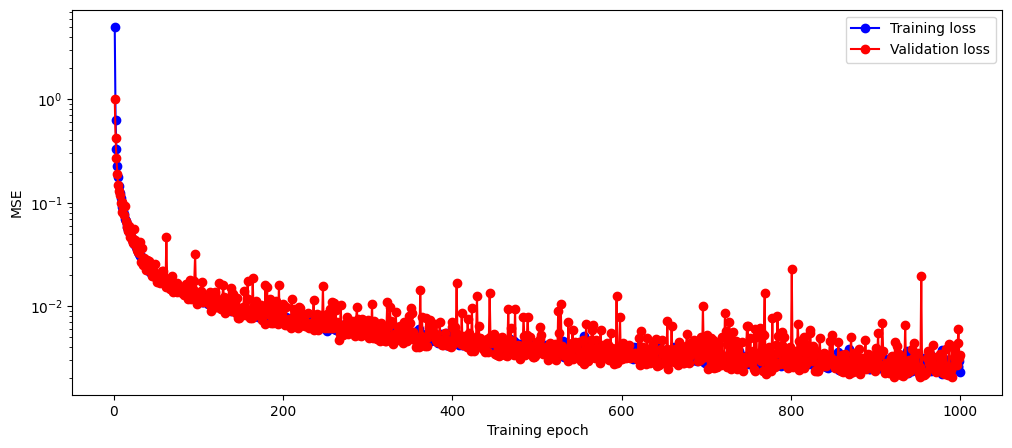

In [8]:
# Plot the loss curves
train_loss = pcatraining.tf_training_history.history["loss"]
val_loss = pcatraining.tf_training_history.history["val_loss"]
plt.figure(figsize=(12, 5))
plt.plot([i+1 for i in range(len(train_loss))], train_loss, '-o', color="blue", label="Training loss")
plt.plot([i+1 for i in range(len(val_loss))], val_loss, '-o', color="red", label="Validation loss")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

In [9]:
training_params, training_log_fluxes = pcatraining.get_params_and_data_as_arrays()
training_fluxes = np.exp(training_log_fluxes)

In [98]:
param_ind = 24100

param = training_params[param_ind]


rescaled_param = (param-pcatraining.min_params)/(pcatraining.max_params - pcatraining.min_params)
prediction = pcatraining.tf_model.predict(np.array([rescaled_param]))

rescaled_flux = pcatraining.pca.inverse_transform(prediction)

rescaled_flux = rescaled_flux.reshape(256,256)
logflux = rescaled_flux*(pcatraining.max_data-pcatraining.min_data) + pcatraining.min_data
mJys = np.exp(logflux)
Jys = 1e-3*mJys

Jy = interpolate.interp1d(pcatraining.sample_freqs, Jys, axis =1)(2.418E+17)
mag_AB = -48.6 - np.log10(Jy/1e23)*2.5


1/1 [==============================] - 0s 23ms/step


In [18]:
def afterglowpy_flux(param): ## define this function for comparison
    Z = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Spectrum
         'thetaObs':    20*np.pi/180,   # Viewing angle in radians
         'E0':          10**50.5, # Isotropic-equivalent energy in erg
         'g0':          1000,
         'thetaCore':   20*np.pi/180,    # Half-opening angle in radians
         #'thetaWing':   0.2,   # Wing angle in radians
         'n0':          10**(-1.1),    # circumburst density in cm^{-3}
         'p':           2.5,    # electron energy distribution index
         'epsilon_e':   10**(-1.6),    # epsilon_e
         'epsilon_B':   10**(-1.8),   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         3.09e26, # Luminosity distance in cm
         'z':           0.0099}   # redshift
    
    keys = ["n0", "thetaObs", "E0", "thetaCore", "p", "epsilon_e", "epsilon_B"]
    ts_, freqs_ = np.meshgrid(pcatraining.sample_times, pcatraining.sample_freqs)
    loc_param = param.copy()

    loc_param[[0,2,5,6]] = 10**(loc_param[[0,2,5,6]])
    
    for key, val in zip(keys, loc_param):
        Z[key] = val
    
    compare_flux =grb.fluxDensity(ts_.flatten(), freqs_.flatten(), **Z)
    compare_flux = np.reshape(compare_flux, newshape=ts_.shape)

    return compare_flux#-48.6 - np.log10(1e-3*compare_flux/1e23)*2.5#compare_flux

In [19]:
training_mJys = np.exp(training_log_fluxes[param_ind])
training_Jys = 1e-3*training_mJys
training_Jy = interpolate.interp1d(pcatraining.sample_freqs, training_Jys, axis =1)(2.418E+17)
training_mag_AB = -48.6 - np.log10(training_Jy/1e23)*2.5

afterglowpy_mJys = afterglowpy_flux(param)
afterglowpy_Jys = 1e-3*afterglowpy_mJys
afterglowpy_Jy = interpolate.interp1d(pcatraining.sample_freqs, afterglowpy_Jys, axis =1)(2.418E+17)
afterglowpy_mag_AB = -48.6 - np.log10(afterglowpy_Jy/1e23)*2.5
afterglowpy_mag_AB = afterglowpy_flux(param)

ValueError: theta_obs must be in [0.0, pi/2]

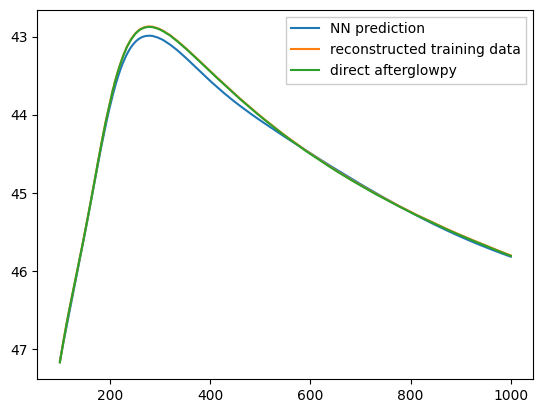

In [101]:
plt.plot(pcatraining.sample_times/(3600*24), mag_AB, label = "NN prediction")
plt.plot(pcatraining.sample_times/(3600*24), training_mag_AB, label = "reconstructed training data")
plt.plot(pcatraining.sample_times/(3600*24), afterglowpy_mag_AB, label = "direct afterglowpy")
plt.gca().invert_yaxis()
plt.legend(fancybox = False, framealpha = 1)
plt.show()

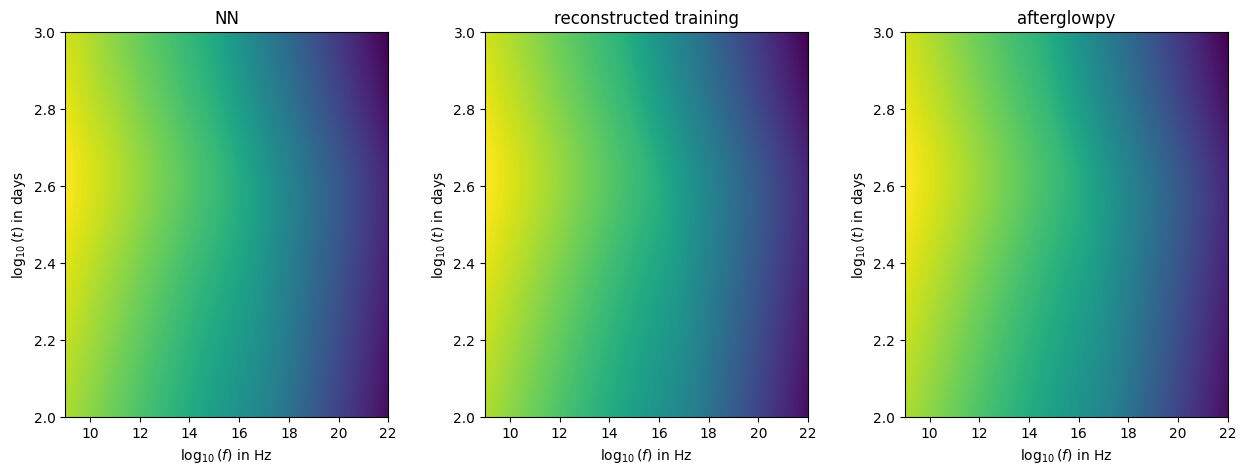

In [151]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.subplots_adjust(wspace = 0.3)
extent = (np.log10(pcatraining.sample_freqs[0]), np.log10(pcatraining.sample_freqs[-1]), np.log10(pcatraining.sample_times[0]/(24*3600)), np.log10(pcatraining.sample_times[-1]/(24*3600)))

ax[0].imshow(logflux, extent = extent, aspect = "auto")

ax[1].imshow(training_log_fluxes[param_ind], extent = extent, aspect = "auto")

ax[2].imshow(np.log(afterglowpy_mJys).T, extent = extent, aspect = "auto")


for cax, title in zip(ax, ["NN", "reconstructed training data", "afterglowpy"]):

    cax.set(ylabel = "$\log_{10}(t)$ in days", xlabel = "$\log_{10}(f)$ in Hz")
    cax.set_title(title)
    #cax.set_yticks(np.arange(len(pcatraining.sample_freqs[::50])), pcatraining.sample_freqs[::50])
    #cax.set_xticks(pcatraining.sample_times[::50])

## saving the model

saving the tensorflow NN and PCA model

In [150]:
pcatraining.save_pcamodel()

/home/enlil/hkoehn/miniconda3/envs/nmma/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## load the model

In [5]:
from training import PCATrainingModel
pcatraining = PCATrainingModel(
                 "afterglowpy_tophat",
                 None,
                 ['log10_n0', 'theta_obs', 'log10_E0', 'thetaCore', 'p', 'log10_eps_e', 'log10_eps_b'],
                 ts,
                 freqs, 
                 50, 
                 "./pca_afterglowpy_tophat"
                 )

pcatraining.load_pcamodel()

2024-04-02 12:16:03.091143: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 12:16:03.095440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 12:16:03.133460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 12:16:03.133495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 12:16:03.134638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [25]:

param = np.array([-3., 1.570796e+00, 52., 8.72664626e-02, 2.60000000e+00, -1., np.log10(5.00000000e-01)])
t, mag = pcatraining.calc_lc(param, 2.418E+17)


afterglowpy_mJys = afterglowpy_flux(param)
afterglowpy_Jys = 1e-3*afterglowpy_mJys
afterglowpy_Jy = interpolate.interp1d(pcatraining.sample_freqs, afterglowpy_Jys, axis =1)(2.418E+17)
afterglowpy_mag_AB = -48.6 - np.log10(afterglowpy_Jy/1e23)*2.5

1/1 [==============================] - 0s 26ms/step


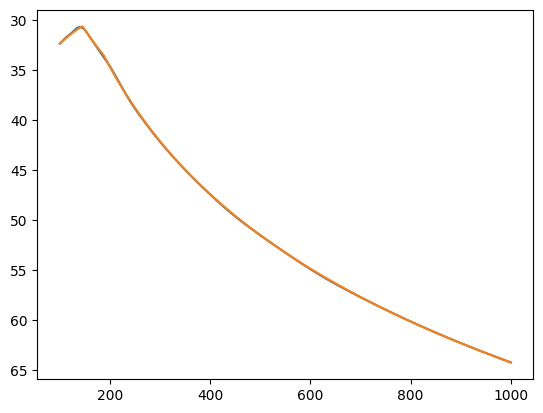

In [26]:
plt.plot(t/(24*3600), mag)
plt.plot(t/(24*3600), afterglowpy_mag_AB)
plt.gca().invert_yaxis()

We have used Principal component analysis to reduce data. For the reconstruction of the data, we need to keep a sufficient amount of components. To find out how many, we ran a test where we load and plot the results here.

Text(0, 0.5, 'Frobenius norm')

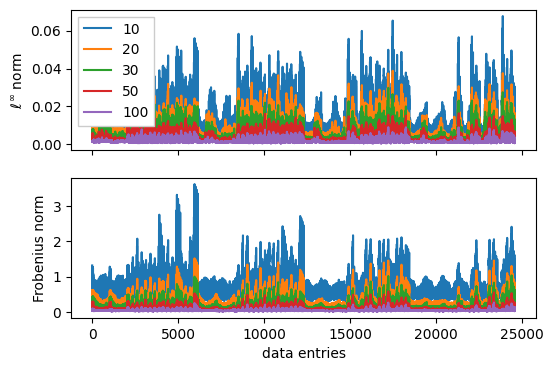

In [170]:
with open("comp_test.json") as f:
    comp_test = json.load(f)


fig, ax = plt.subplots(2,1, figsize = (6,4), sharex = True)
for key in comp_test.keys():
    ax[0].plot(comp_test[key]["max"], label= key)
    ax[1].plot(comp_test[key]["Frobenius"], label = key)

ax[0].legend(fancybox = False, framealpha = 1)
ax[1].set_xlabel("data entries")

ax[0].set_ylabel("$\\ell^{\\infty}$ norm")
ax[1].set_ylabel("Frobenius norm")

Apparently, some data is harder to recover than other data. Overall, 50 components should be sufficient (maybe 100?).

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Sandbox

In [244]:
keys = ["n0", "thetaObs", "E0", "thetaCore", "p", "epsilon_e", "epsilon_B"]
ts_, freqs_ = np.meshgrid(ts, freqs)

def tf_model_flux(param):

    rescaled_param = (param-min_params)/(max_params- min_params)
    
    pca_components = model.predict(np.array([[rescaled_param]]))
    rescaled_output = pca.inverse_transform(pca_components)
    
    rescaled_output.reshape(256, 256)
    log_flux = rescaled_output.reshape(256,256)*(max_data-min_data) + min_data

    return log_flux

def afterglowpy_flux(param):
    Z = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Spectrum
         'thetaObs':    20*np.pi/180,   # Viewing angle in radians
         'E0':          10**50.5, # Isotropic-equivalent energy in erg
         'g0':          1000,
         'thetaCore':   20*np.pi/180,    # Half-opening angle in radians
         #'thetaWing':   0.2,   # Wing angle in radians
         'n0':          10**(-1.1),    # circumburst density in cm^{-3}
         'p':           2.5,    # electron energy distribution index
         'epsilon_e':   10**(-1.6),    # epsilon_e
         'epsilon_B':   10**(-1.8),   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         3.09e26, # Luminosity distance in cm
         'z':           0.0099}   # redshift
    
    keys = ["n0", "thetaObs", "E0", "thetaCore", "p", "epsilon_e", "epsilon_B"]
    ts_, freqs_ = np.meshgrid(pcatraining.sample_times, pcatraining.sample_freqs)
    loc_param = param.copy()

    loc_param[[0,2,5,6]] = 10**(loc_param[[0,2,5,6]])
    
    for key, val in zip(keys, loc_param):
        Z[key] = val
    
    compare_flux =grb.fluxDensity(ts_.flatten(), freqs_.flatten(), **Z)
    compare_flux = np.reshape(compare_flux, newshape=ts_.shape)

    return np.log(compare_flux)

In [245]:

test_param = params[0].copy()
test_param[[0,2,5,6]] = np.log10(test_param[[0,2,5,6]])   #np.array([-1.1, 20*np.pi/180, 50.5, 20*np.pi/180, 2.5, -1.6, -1.8])

test_flux = tf_model_flux(test_param)
training_flux = rescaled_data[0].reshape(256, 256)*(max_data-min_data) + min_data #afterglowpy_flux(test_param)
afterglow_flux = afterglowpy_flux(test_param)

#plt.imshow(test_flux)

1/1 [==============================] - 0s 20ms/step


{'jetType': -1, 'specType': 0, 'thetaObs': 0.0, 'E0': 9.999999999999999e+49, 'g0': 1000, 'thetaCore': 0.08726646259971647, 'n0': 1.0, 'p': 2.2, 'epsilon_e': 0.5, 'epsilon_B': 0.5, 'xi_N': 1.0, 'd_L': 3.09e+26, 'z': 0.0099}


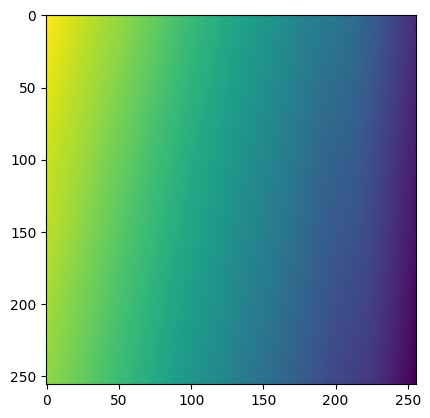

In [246]:
plt.imshow(test_flux)


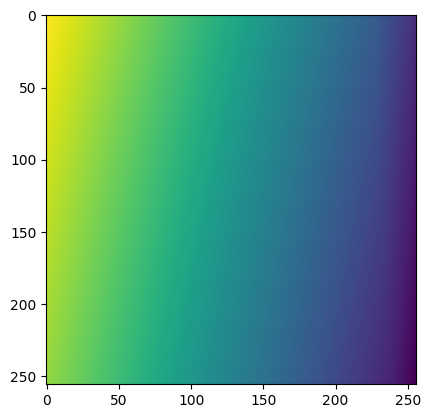

In [237]:
plt.imshow(training_flux)

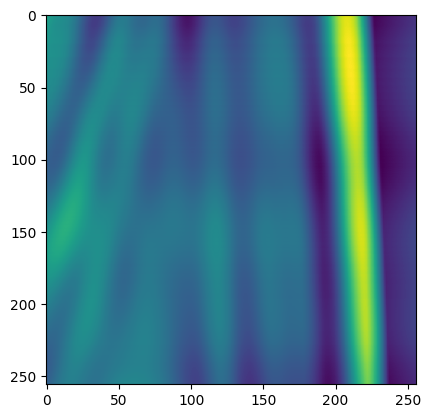

In [241]:
plt.imshow(test_flux - training_flux)

In [258]:
afterglow_flux.T

array([[ -3.48589599,  -3.556328  ,  -3.62676002, ..., -29.78358237,
        -29.91270773, -30.04183309],
       [ -3.49726667,  -3.56769868,  -3.63813069, ..., -29.79324096,
        -29.92236632, -30.05149168],
       [ -3.51062569,  -3.5810577 ,  -3.65148972, ..., -29.80486473,
        -29.93399009, -30.06311545],
       ...,
       [ -6.54397348,  -6.61440549,  -6.68483751, ..., -32.64055063,
        -32.76967599, -32.89880135],
       [ -6.55612896,  -6.62656098,  -6.69699299, ..., -32.65263197,
        -32.78175733, -32.91088269],
       [ -6.56732262,  -6.63775463,  -6.70818664, ..., -32.66375805,
        -32.79288341, -32.92200877]])

In [257]:
np.log(fluxes[0])

array([[-17.78042347, -17.85085548, -17.92128749, ..., -37.17305212,
        -37.30217748, -37.43130284],
       [-17.79710185, -17.86753386, -17.93796588, ..., -37.18698992,
        -37.31611528, -37.44524064],
       [-17.81377139, -17.8842034 , -17.95463542, ..., -37.2009157 ,
        -37.33004106, -37.45916642],
       ...,
       [-21.4140558 , -21.48448782, -21.55491983, ..., -40.17607536,
        -40.30520072, -40.43432608],
       [-21.42740002, -21.49783204, -21.56826405, ..., -40.18765963,
        -40.31678499, -40.44591035],
       [-21.44076564, -21.51119765, -21.58162967, ..., -40.19927331,
        -40.32839867, -40.45752403]])